In [1]:
import sys

import sklearn
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Данните може да се изтеглят от [тук](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data).

In [2]:
data = pd.read_csv("fer2013.csv")

In [6]:
data["Usage"].unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [7]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [90]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

Изглежда самото изображение е string от числа от 0 до 255, вместо просто списък от числа.

Нека видим едно изображение, за да се уверим, че можем да декодираме информацията правилно

In [91]:
image_to_show = np.array(list(map(lambda x: int(x), data.iloc[0]["pixels"].split(" "))))

Text(0.5,1,'Angry')

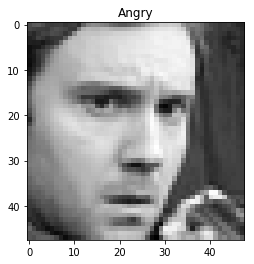

In [92]:
plt.imshow(image_to_show.reshape(48, 48),cmap='gray')
plt.title("Angry")

In [27]:
train = data[data.Usage == "Training"]
test = data[data.Usage == "PrivateTest"]
test_pub = data[data.Usage == "PublicTest"]

In [29]:
test_pub.head()

,emotion,pixels,Usage
28709,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
28710,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest
28711,4,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,PublicTest
28712,6,205 203 236 157 83 158 120 116 94 86 155 180 2...,PublicTest
28713,3,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,PublicTest


In [36]:
len(train)

28709

In [41]:
len(test)

3589

In [93]:
len(test_pub)

3589

PublicTest частта е използвана за leaderboard-a за състезанието в kaggle, PrivateTest е било използвано за определяне на победителя.  

In [80]:
train_labels = train["emotion"].values
test_labels = test["emotion"].values
test_pub_labels = test_pub["emotion"].values

In [31]:
train_ds = train["pixels"]
test_ds = test["pixels"]
test_pub_ds = test_pub["pixels"]

In [32]:
train_ds = train_ds.values
test_ds = test_ds.values
test_pub_ds = test_pub_ds.values

In [42]:
type(train_ds)

numpy.ndarray

In [15]:
train_alt = list(map(lambda x: x.split(" "), train_ds))

In [16]:
train_alt = list(map(lambda x: list(map(lambda y : int(y), x)), train_alt))

In [33]:
test_alt = list(map(lambda x: x.split(" "), test_ds))

In [34]:
test_alt = list(map(lambda x: list(map(lambda y : int(y), x)), test_alt))

In [37]:
test_pub_alt = list(map(lambda x: x.split(" "), test_pub_ds))

In [38]:
test_pub_alt = list(map(lambda x: list(map(lambda y : int(y), x)), test_pub_alt))

Запазвам dataset-a в по-нормален вид...

In [44]:
import os
import pickle

In [87]:
pickle_file = os.path.join(".", 'faces_dataset_conv.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_ds,
    'train_labels': train_labels,
    'public_test': test_pub_ds,
    'public_test_labels': test_pub_labels,
    'private_test': test_ds,
    'private_test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [47]:
import tensorflow as tf

Време е да пробваме един baseline конволюционен модел.

In [75]:
def cnn_model(features, labels, mode):
    input_layer = tf.reshape(features["x"], [-1, image_size, image_size, 1])
    
    #output [batch_size, 48, 48, 32]
    conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    #output [batch_size, 24, 24, 32]
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    #output [batch_size, 24, 24, 64]
    conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
    #output [batch_size, 12 , 12 , 64]
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    pool2_flat = tf.reshape(pool2, [-1, 12 * 12 * 64])
    
     # Output Tensor Shape: [batch_size, 1024]
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    
    dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=dropout, units=num_labels)
    
    predictions = {
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [96]:
baseline_classifier = tf.estimator.Estimator(
      model_fn=cnn_model, model_dir="./baseline_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './baseline_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002BB456C47B8>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [84]:
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
      tensors=tensors_to_log, every_n_iter=1000)

In [97]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": train_ds},
      y=train_labels,
      batch_size=128,
      num_epochs=None,
      shuffle=True)
baseline_classifier.train(
      input_fn=train_input_fn,
      steps=10000,
      hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into ./baseline_convnet_model\model.ckpt.
INFO:tensorflow:probabilities = [[0.1694895  0.15486313 0.14008783 0.13382241 0.1421087  0.11730883
  0.1423195 ]
 [0.16077466 0.15391609 0.13690382 0.14118946 0.13422486 0.12306768
  0.14992337]
 [0.14973485 0.15896161 0.13927233 0.14188895 0.1387474  0.12078292
  0.15061197]
 [0.15906553 0.14748731 0.14472258 0.13766281 0.14072524 0.13248184
  0.13785468]
 [0.16215791 0.13971785 0.13966641 0.1480794  0.13888264 0.13078707
  0.14070874]
 [0.15060888 0.15326656 0.13731094 0.14708048 0.134684   0.12612598
  0.1509232 ]
 [0.16854553 0.15308626 0.12505855 0.14143503 0.13131268 0.12821348
  0.15234853]
 [0.1697265  0.1495174  0.13861677 0.1476515  0.13575278 0.12085482
  0.13788019]
 [0.14956492 0.16276789 0.14160143 0.14221929 0.13770577 0.13215937
  0.1339813 ]
 [0.15350714 0.16926952 0.12687035 0.13523239 0.13729951 0.13485567
  0.1429654 ]
 [0.16473384 0.157916

In [98]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": test_ds},
      y=test_labels,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-05-15-11:24:48
INFO:tensorflow:Restoring parameters from ./baseline_convnet_model\model.ckpt-10000
INFO:tensorflow:Finished evaluation at 2018-05-15-11:24:49
INFO:tensorflow:Saving dict for global step 10000: accuracy = 0.34940094, global_step = 10000, loss = 1.6903446
{'accuracy': 0.34940094, 'loss': 1.6903446, 'global_step': 10000}


Точността е 0.349 при 7 класа, което означава че на random вероятността е :

In [99]:
1 / 7

0.14285714285714285

Да пробваме с още 10к итерации.

In [100]:
baseline_classifier.train(
      input_fn=train_input_fn,
      steps=10000,
      hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./baseline_convnet_model\model.ckpt-10000
INFO:tensorflow:Saving checkpoints for 10001 into ./baseline_convnet_model\model.ckpt.
INFO:tensorflow:probabilities = [[0.16304225 0.01660792 0.10018753 0.2115648  0.13201182 0.1346714
  0.24191433]
 [0.15381567 0.02297955 0.08020675 0.42746842 0.10686628 0.04886451
  0.15979877]
 [0.07808436 0.01398286 0.11992168 0.42040822 0.05967361 0.1373241
  0.17060521]
 [0.09559618 0.01643461 0.1781339  0.35005966 0.09498674 0.17364815
  0.09114072]
 [0.08180663 0.01792854 0.13435318 0.3984081  0.09064178 0.11823925
  0.15862255]
 [0.10609256 0.02580049 0.14262731 0.3401744  0.15052852 0.08028729
  0.15448947]
 [0.11643387 0.016805   0.1547617  0.24329531 0.13862817 0.09500865
  0.23506734]
 [0.09425001 0.01037022 0.13357621 0.45732504 0.13874894 0.07505152
  0.09067804]
 [0.10165706 0.01456129 0.17583564 0.15479505 0.09883874 0.29319844
  0.16111389]
 [0.11799891 0.01

In [101]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": test_ds},
      y=test_labels,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-05-15-11:41:12
INFO:tensorflow:Restoring parameters from ./baseline_convnet_model\model.ckpt-20000
INFO:tensorflow:Finished evaluation at 2018-05-15-11:41:14
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.3967679, global_step = 20000, loss = 1.588814
{'accuracy': 0.3967679, 'loss': 1.588814, 'global_step': 20000}


Почти 5% подобрение, изглежда има полза от още итерации. 

Да пробваме с още. 

In [102]:
baseline_classifier.train(
      input_fn=train_input_fn,
      steps=20000,
      hooks=[logging_hook])

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from ./baseline_convnet_model\model.ckpt-20000
INFO:tensorflow:Saving checkpoints for 20001 into ./baseline_convnet_model\model.ckpt.
INFO:tensorflow:probabilities = [[0.04383501 0.0206692  0.1888026  0.02763196 0.07778472 0.51524067
  0.12603588]
 [0.22754289 0.01553742 0.08541439 0.4583831  0.11231074 0.01634064
  0.0844708 ]
 [0.09812439 0.0103598  0.06061726 0.49721572 0.08797355 0.01316388
  0.2325454 ]
 [0.1617703  0.02660256 0.23168057 0.08035614 0.30409685 0.1019166
  0.09357703]
 [0.08342663 0.022628   0.2270806  0.18667363 0.10965557 0.13425852
  0.23627709]
 [0.09972581 0.0022606  0.02807221 0.5245797  0.2364846  0.00416483
  0.10471228]
 [0.11712081 0.01136397 0.29187295 0.08503309 0.22612531 0.07387173
  0.19461213]
 [0.10335414 0.01229597 0.17921498 0.41046703 0.13788866 0.04948122
  0.10729807]
 [0.16075778 0.00754702 0.252101   0.08254788 0.29590425 0.05149617
  0.14964592]
 [0.13251424 0.0

In [103]:
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
      x={"x": test_ds},
      y=test_labels,
      num_epochs=1,
      shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-05-15-12:23:55
INFO:tensorflow:Restoring parameters from ./baseline_convnet_model\model.ckpt-40000
INFO:tensorflow:Finished evaluation at 2018-05-15-12:23:56
INFO:tensorflow:Saving dict for global step 40000: accuracy = 0.4321538, global_step = 40000, loss = 1.4621862
{'accuracy': 0.4321538, 'loss': 1.4621862, 'global_step': 40000}


Още към 4% подобрение. Изглежда дори с този модел има смисъл от още трениране.